In [10]:
from utils import *
import pandas as pd
import datetime as dt

opt_data = pd.read_csv('./data/options.csv')
ibit_data = pd.read_csv('./data/ibit-usd-intraday.csv')[["Datetime", "Adj Close"]]
ibit_data["Datetime"] = pd.to_datetime(ibit_data["Datetime"]).dt.tz_localize(None)


opt_data["Expiration_date"] = pd.to_datetime(opt_data["Expiration_date"]).dt.tz_localize(None)
opt_data["lastTradeDate"] = pd.to_datetime(opt_data["lastTradeDate"]).dt.tz_localize(None)

opt_data = opt_data[["contractSymbol", "lastTradeDate", "Expiration_date", "strike", "lastPrice"]]
opt_data["days_to_expiration"] = (opt_data["Expiration_date"] - opt_data['lastTradeDate']).dt.days
opt_data

,contractSymbol,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration
0,IBIT241220C00030000,2024-11-22 20:58:37,2024-12-20,30.0,26.70,27
1,IBIT241220C00036000,2024-11-21 14:34:42,2024-12-20,36.0,19.40,28
2,IBIT241220C00037000,2024-11-19 18:49:06,2024-12-20,37.0,17.00,30
3,IBIT241220C00038000,2024-11-21 17:45:27,2024-12-20,38.0,18.20,28
4,IBIT241220C00040000,2024-11-22 20:42:42,2024-12-20,40.0,16.82,27
...,...,...,...,...,...,...
247,IBIT270115C00080000,2024-11-22 20:47:32,2027-01-15,80.0,22.40,783
248,IBIT270115C00085000,2024-11-22 16:44:42,2027-01-15,85.0,20.60,783
249,IBIT270115C00090000,2024-11-22 19:30:16,2027-01-15,90.0,20.60,783
250,IBIT270115C00095000,2024-11-22 19:55:12,2027-01-15,95.0,20.45,783


In [11]:
opt_data.sort_values(by=["lastTradeDate", "Expiration_date", "strike"], inplace=True)

In [12]:
merged_df = pd.merge_ordered(ibit_data, opt_data, left_on="Datetime", right_on="lastTradeDate")
merged_df[["Datetime", "Adj Close"]] = merged_df[["Datetime", "Adj Close"]].fillna(method="ffill")
merged_df.dropna(subset="contractSymbol", inplace=True)
merged_df = merged_df[["Adj Close", "lastTradeDate", "Expiration_date", "strike", "lastPrice", "days_to_expiration"]].reset_index(drop=True)

C:\Users\Andre\AppData\Local\Temp\ipykernel_17588\1833394939.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[["Datetime", "Adj Close"]] = merged_df[["Datetime", "Adj Close"]].fillna(method="ffill")


In [13]:
merged_df

,Adj Close,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration
0,53.110001,2024-11-19 15:28:56,2025-02-21,36.0,17.70,93.0
1,53.020000,2024-11-19 15:38:41,2025-01-17,39.0,14.75,58.0
2,52.709999,2024-11-19 18:49:06,2024-12-20,37.0,17.00,30.0
3,52.709999,2024-11-19 19:02:40,2026-01-16,49.0,20.50,422.0
4,52.709999,2024-11-19 19:35:35,2025-02-21,41.0,15.39,93.0
...,...,...,...,...,...,...
247,56.490002,2024-11-22 20:59:38,2024-12-20,57.0,3.83,27.0
248,56.490002,2024-11-22 20:59:38,2025-01-17,46.0,12.34,55.0
249,56.490002,2024-11-22 20:59:43,2024-12-20,60.0,2.71,27.0
250,56.490002,2024-11-22 20:59:47,2025-05-16,60.0,10.65,174.0


In [ ]:
def freitas2(S, X, T, r, sigma):
    mi_ST = np.log(S)
    sigma_ST = np.sqrt(T)*sigma

    def ret_lin(s, C):
        return (s-(X+C))*(1/(s*sigma_ST*np.sqrt(2*np.pi)))*np.exp(-(np.log(s)-mi_ST)**2/(2*sigma_ST**2))

    def ret_ct(s, C):
        return -C*(1/(s*sigma_ST*np.sqrt(2*np.pi)))*np.exp(-(np.log(s)-mi_ST)**2/(2*sigma_ST**2))

    def diferenca_esperancas(C):
        Pt = quad(ret_ct, 0, X, args=(C))[0]
        Pp = quad(ret_lin, X, X + C, args=(C))[0]
        L = quad(ret_lin, X + C, np.inf, args=(C))[0]
        D = abs(L + Pt + Pp)
        return D

    C_freitas = minimize_scalar(diferenca_esperancas).x / (1 + r)**T

    return C_freitas

In [53]:
mi, sigma, r = pd.read_csv('./data/parameters.csv').values[0]

merged_df["BS"] = merged_df.apply(lambda x: black_scholes(x["Adj Close"], x["strike"], x["days_to_expiration"], r, sigma), axis=1)

merged_df["Freitas"] = merged_df.apply(lambda x: freitas2(x["Adj Close"], x["strike"], x["days_to_expiration"], r, mi, sigma), axis=1)

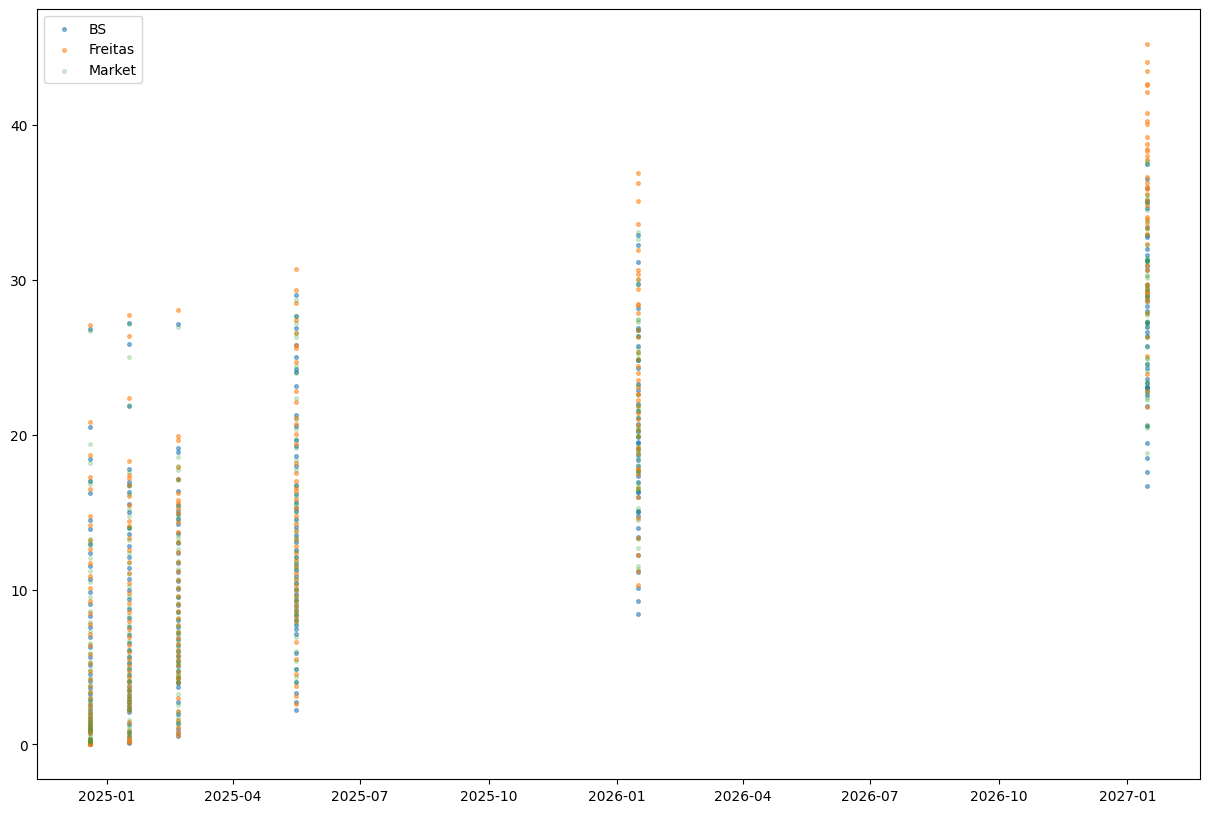

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.scatter(merged_df["Expiration_date"], merged_df["BS"], label="BS", alpha=0.5, s=7)
plt.scatter(merged_df["Expiration_date"], merged_df["Freitas"], label="Freitas", alpha=0.5, s=7)
plt.scatter(merged_df["Expiration_date"], merged_df["lastPrice"], label="Market", alpha=0.2, s=7)

plt.legend()

plt.show()

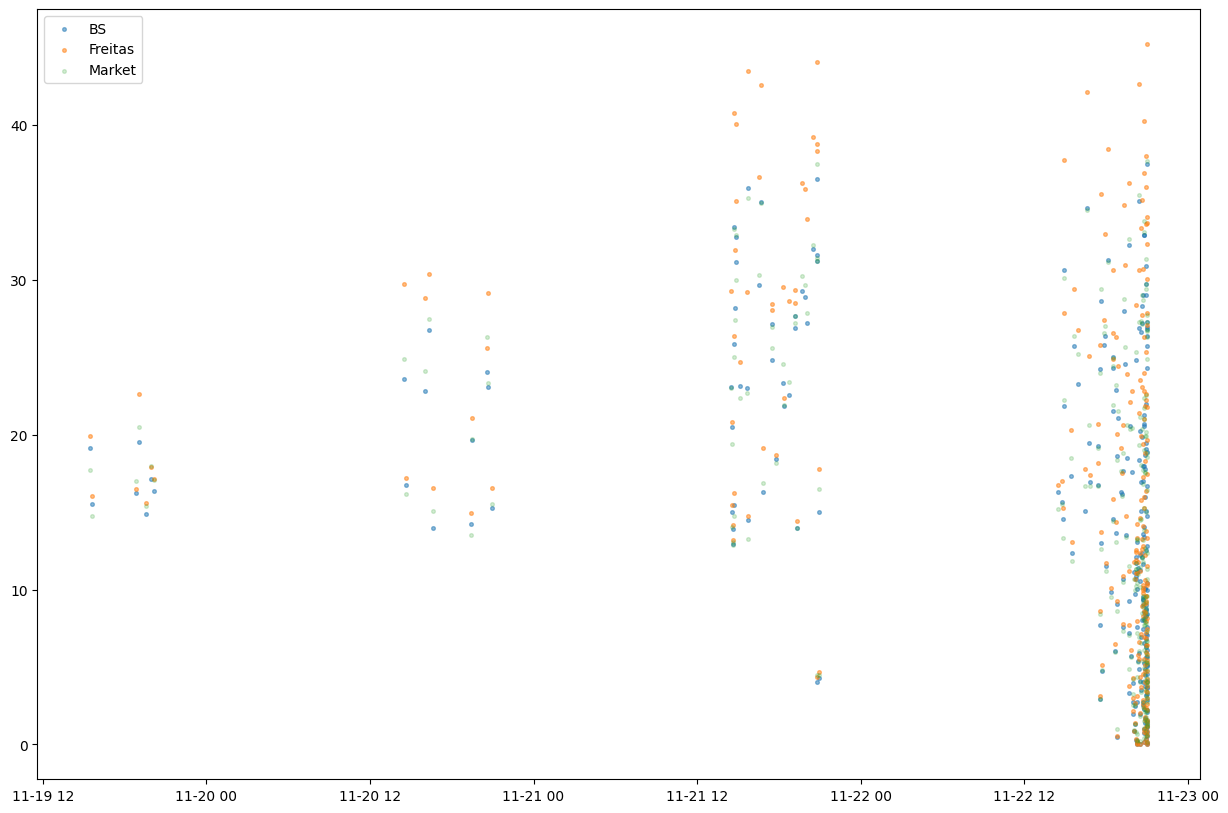

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.scatter(merged_df["lastTradeDate"], merged_df["BS"], label="BS", alpha=0.5, s=7)
plt.scatter(merged_df["lastTradeDate"], merged_df["Freitas"], label="Freitas", alpha=0.5, s=7)
plt.scatter(merged_df["lastTradeDate"], merged_df["lastPrice"], label="Market", alpha=0.2, s=7)

plt.legend()

plt.show()

In [56]:
merged_df[merged_df['Freitas'] > merged_df['lastPrice']]

,Adj Close,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration,BS,Freitas
0,53.110001,2024-11-19 15:28:56,2025-02-21,36.0,17.70,93.0,19.146002,19.949538
1,53.020000,2024-11-19 15:38:41,2025-01-17,39.0,14.75,58.0,15.533331,16.027218
3,52.709999,2024-11-19 19:02:40,2026-01-16,49.0,20.50,422.0,19.553943,22.660918
4,52.709999,2024-11-19 19:35:35,2025-02-21,41.0,15.39,93.0,14.860225,15.594275
6,52.709999,2024-11-19 20:08:15,2025-02-21,39.0,17.10,93.0,16.366002,17.126966
...,...,...,...,...,...,...,...,...
247,56.490002,2024-11-22 20:59:38,2024-12-20,57.0,3.83,27.0,4.089049,4.233824
248,56.490002,2024-11-22 20:59:38,2025-01-17,46.0,12.34,55.0,12.838064,13.298876
249,56.490002,2024-11-22 20:59:43,2024-12-20,60.0,2.71,27.0,2.864411,2.978981
250,56.490002,2024-11-22 20:59:47,2025-05-16,60.0,10.65,174.0,10.446996,11.508872
